In [2]:
import numpy as np
import matplotlib.pyplot as plt

from nilearn.plotting import plot_surf
from concon_utils import load_mesh_boris, load_raw_labels_boris, squeeze_matrix, downsample_mesh_faces
%matplotlib inline

In [ ]:
# load meshes from freesurfer from nilearn.surface import load_surf_mesh, load_surf_data
# import nibabel as nib

In [3]:
path = '/home/bgutman/datasets/HCP/'

lh_labels = load_raw_labels_boris(path + 'LH_labels_MajVote.raw') 
lh_CC_vertices, lh_CC_faces = load_mesh_boris(path + 'LH_200_mean_ConCon_res.m')
lh_IC7_vertices, lh_IC7_faces = load_mesh_boris(path + 'LH_200_mean.m')

rh_labels = load_raw_labels_boris(path + 'RH_labels_MajVote.raw') 
rh_CC_vertices, rh_CC_faces = load_mesh_boris(path + 'RH_200_mean_ConCon_res.m')
rh_IC7_vertices, rh_IC7_faces = load_mesh_boris(path + 'RH_200_mean.m')

## Compute labels for ConCon resolution

In [7]:
# same for LH and RH
print('IC7 resolution: \n#vertices: {} #faces: {}'.format(lh_IC7_vertices.shape[0], lh_IC7_faces.shape[0]))

IC7 resolution: 
#vertices: 163842 #faces: 327680


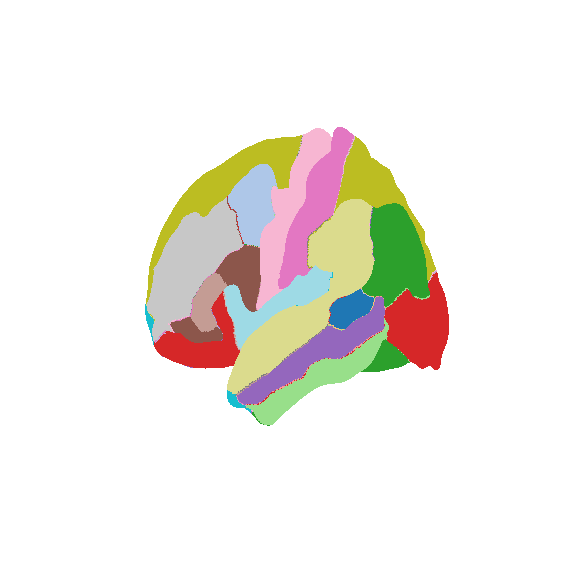

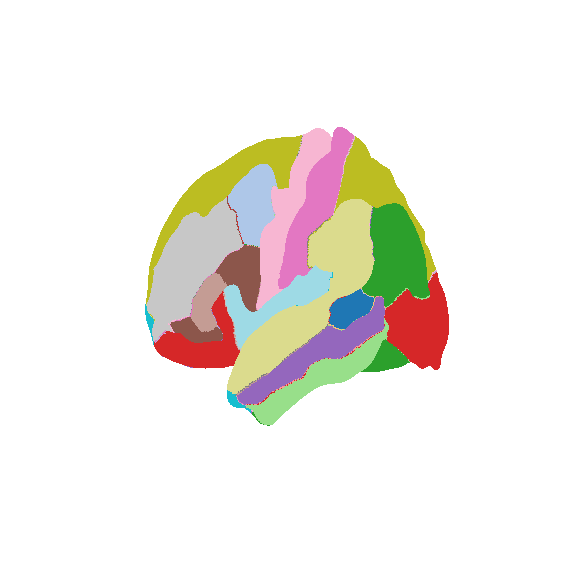

In [4]:
# IC7 from LH_200_mean.m with colors from LH_labels_MajVote.raw
fig = plt.figure(figsize=(10,10))
plot_surf([lh_IC7_vertices, lh_IC7_faces], figure=fig, surf_map =lh_labels, view='lateral', cmap='tab20')

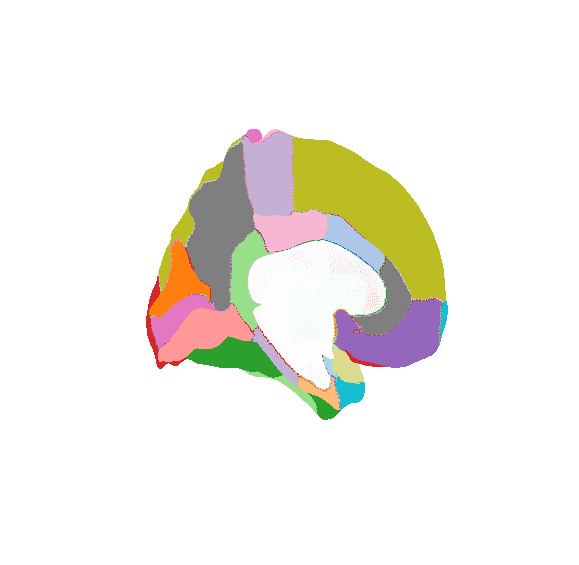

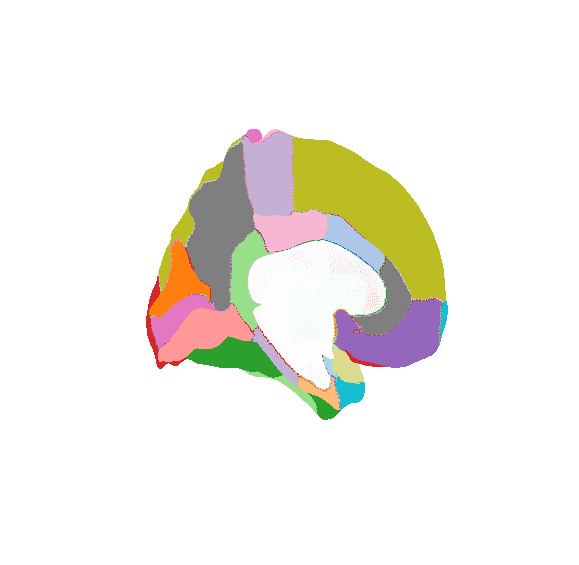

In [8]:
fig = plt.figure(figsize=(10,10))
plot_surf([lh_IC7_vertices, lh_IC7_faces], figure=fig,
          surf_map =lh_labels, view= 'medial', cmap='tab20')

In [9]:
# same for LH and RH
print('ConCon resolution: \n#vertices: {} #faces: {}'.format(lh_CC_vertices.shape[0], lh_CC_faces.shape[0]))

ConCon resolution: 
#vertices: 10242 #faces: 20480


In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(lh_IC7_vertices, lh_labels)
lh_labels_CC = knn.predict(lh_CC_vertices)

knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(rh_IC7_vertices, rh_labels)
rh_labels_CC = knn.predict(rh_CC_vertices)

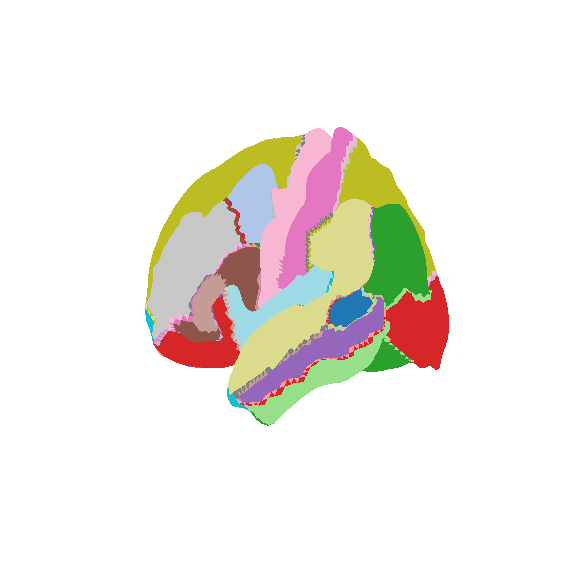

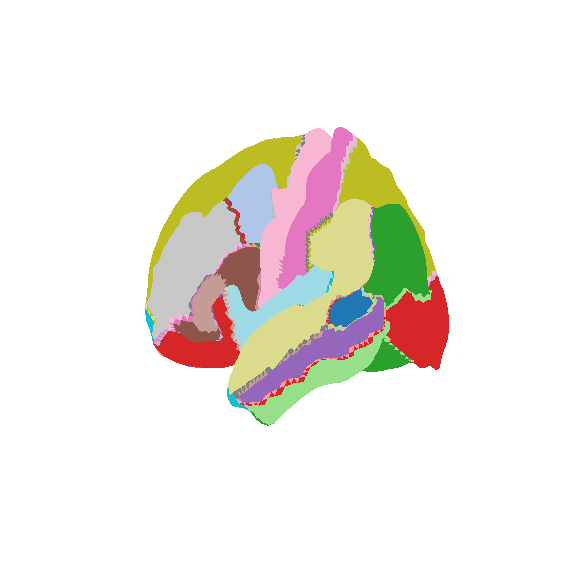

In [12]:
fig = plt.figure(figsize=(10,10))
plot_surf([lh_CC_vertices, lh_CC_faces], figure=fig,
          surf_map =lh_labels_CC, view= 'lateral', cmap='tab20')

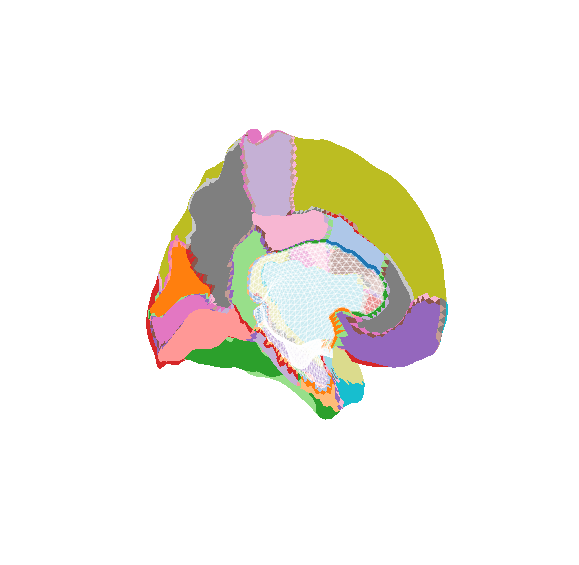

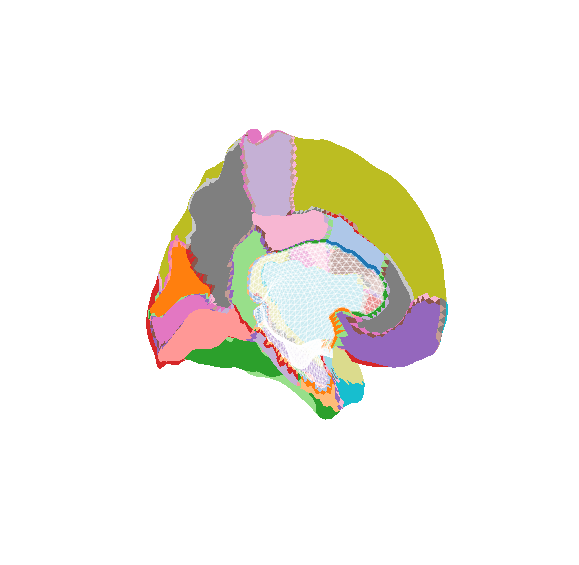

In [13]:
fig = plt.figure(figsize=(10,10))
plot_surf([lh_CC_vertices, lh_CC_faces], figure=fig,
          surf_map =lh_labels_CC, view= 'medial', cmap='tab20')

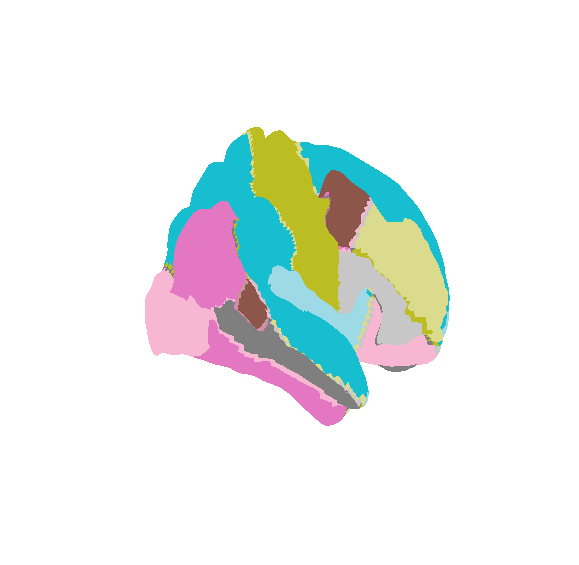

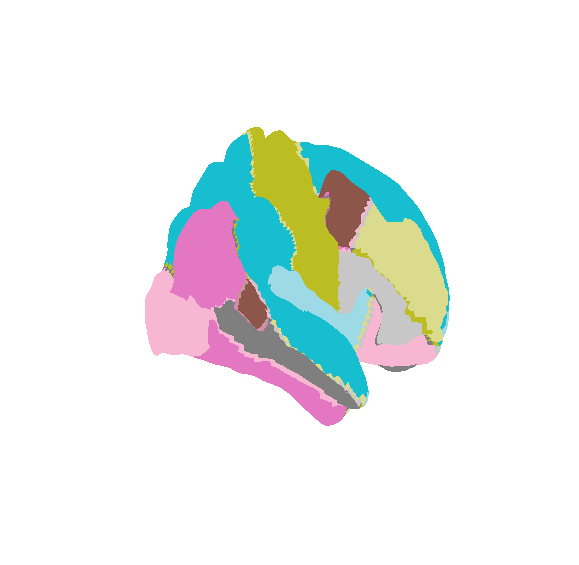

In [19]:
fig = plt.figure(figsize=(10,10))
plot_surf([rh_CC_vertices, rh_CC_faces], figure=fig,
          surf_map =rh_labels_CC, hemi='right', view= 'lateral', cmap='tab20')

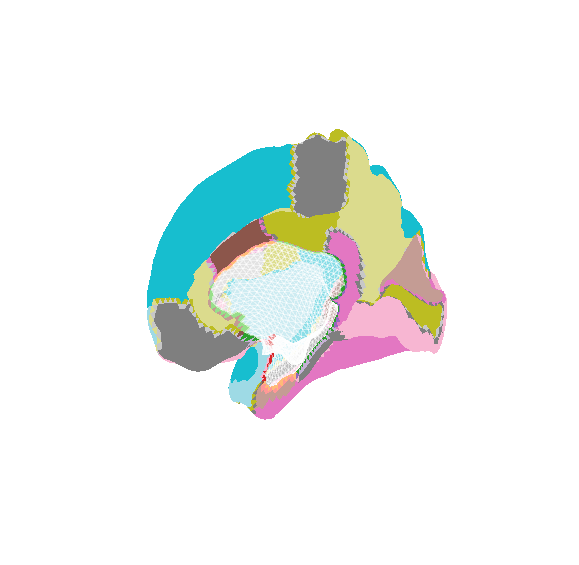

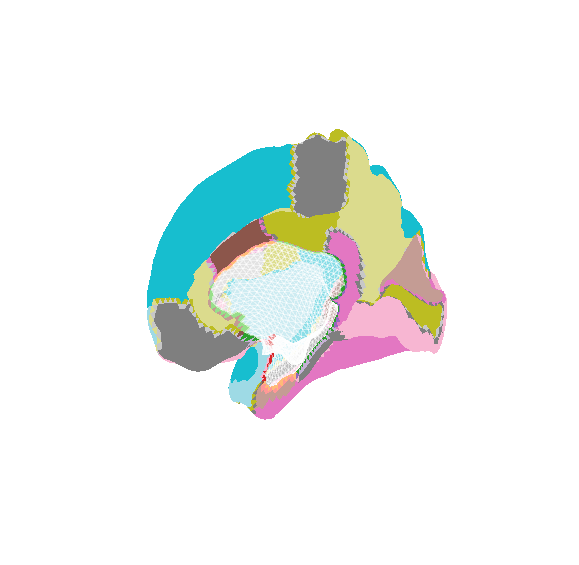

In [21]:
fig = plt.figure(figsize=(10,10))
plot_surf([rh_CC_vertices, rh_CC_faces], figure=fig,
          surf_map =rh_labels_CC, hemi='right', view= 'medial', cmap='tab20')

In [16]:
print(np.unique(lh_labels_CC))

[  0.   1.   2.   3.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.]


In [17]:
print(np.unique(rh_labels_CC))

[  0.  36.  37.  38.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.
  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.
  66.  67.  68.  69.  70.]


## Construct DKT from ConCon

In [22]:
from scipy.sparse import coo_matrix
path = '/cobrain/groups/ml_group/data/sparse_old_concon_HCP'
subj = 185442
filename = '{}/{}.npz'.format(path, subj)

a = np.load(filename)
adj_185442 = coo_matrix((a['data'], (a['row'], a['col'])), shape=a['shape']).toarray()
#np.fill_diagonal(adj_185442, 0)

labels_concon_LR = np.concatenate([lh_labels_CC, rh_labels_CC]).astype(int)
adj_185442_DKT = squeeze_matrix(adj_185442, labels_concon_LR)

In [25]:
# drop 0 row and column as they come from label 0
adj_185442_DKT = adj_185442_DKT[1:, 1:] 

In [26]:
adj_185442_DKT.shape

(68, 68)

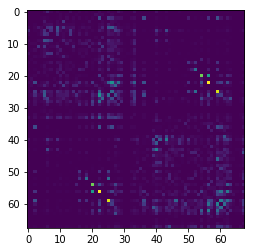

In [28]:
plt.imshow(adj_185442_DKT)

In [29]:
# plot matrix intensities 
from scipy.spatial.distance import squareform

plt.hist(squareform(adj_185442_DKT))

ValueError: Distance matrix 'X' must be symmetric.

In [41]:
print(np.diag(adj_185442_DKT))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [32]:
temp = adj_185442_DKT.copy()

In [35]:
# nvm just a liitle bit not symmetric, lets say approx error
((temp + temp.T) / 2 - adj_185442_DKT).max() 

1.1641532182693481e-10

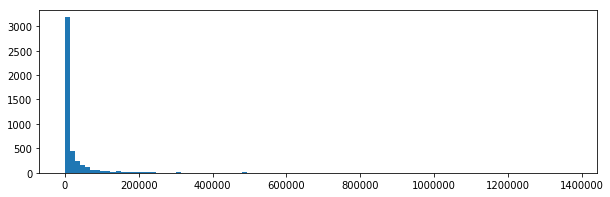

In [38]:
plt.figure(figsize=(10, 3))
plt.hist(adj_185442_DKT.reshape(-1), bins=100);

In [40]:
# WOW
print(adj_185442_DKT.max())

1373801.57744


In [42]:
# load (probably) conventional 68 x 68 connectome

filename = '/home/bgutman/datasets/HCP/Connectomes/185442/con/185442_NxNmatrix_FULL_700350.txt'
adj_185442_DKT_ = np.loadtxt(filename)

In [45]:
adj_185442_DKT_ = adj_185442_DKT_[:70, :70]

adj_185442_DKT_ = np.delete(np.delete(adj_185442_DKT_, [3, 38], axis = 0), [3,38], axis=1)
np.fill_diagonal(adj_185442_DKT_, 0)

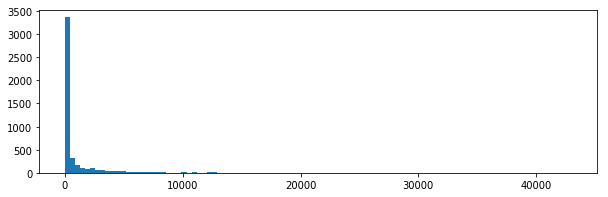

In [47]:
plt.figure(figsize=(10, 3))
plt.hist(adj_185442_DKT_.reshape(-1), bins=100);

In [48]:
print(adj_185442_DKT_.max())

43045.0


Text(0.5,1,'DKT  intensities')

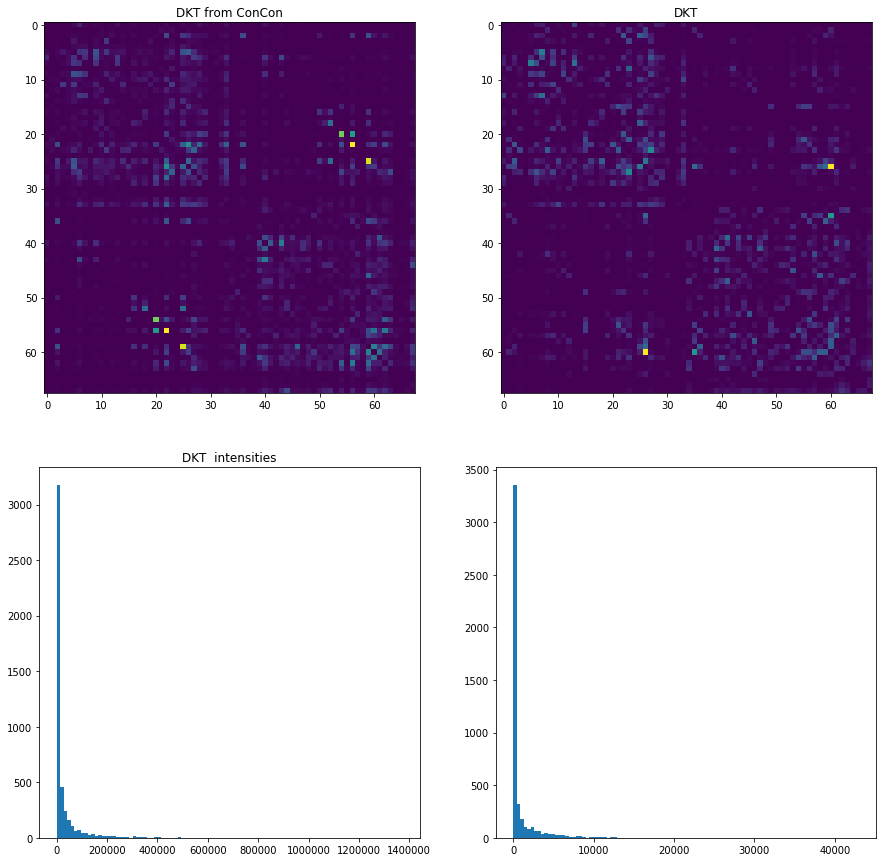

In [55]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].imshow(adj_185442_DKT)
ax[0, 0].set_title('DKT from ConCon')
ax[0, 1].imshow(adj_185442_DKT_)
ax[0, 1].set_title('DKT')
ax[1, 0].hist(adj_185442_DKT.reshape(-1), bins=100);
ax[1, 0].set_title('DKT from ConCon intensities')
ax[1, 1].hist(adj_185442_DKT_.reshape(-1), bins=100);
ax[1, 0].set_title('DKT  intensities')

In [57]:
edges_DKT_CC = squareform((adj_185442_DKT + adj_185442_DKT.T)/2)# almost symmetric with highest error 1e-10
edges_DKT = squareform(adj_185442_DKT_)

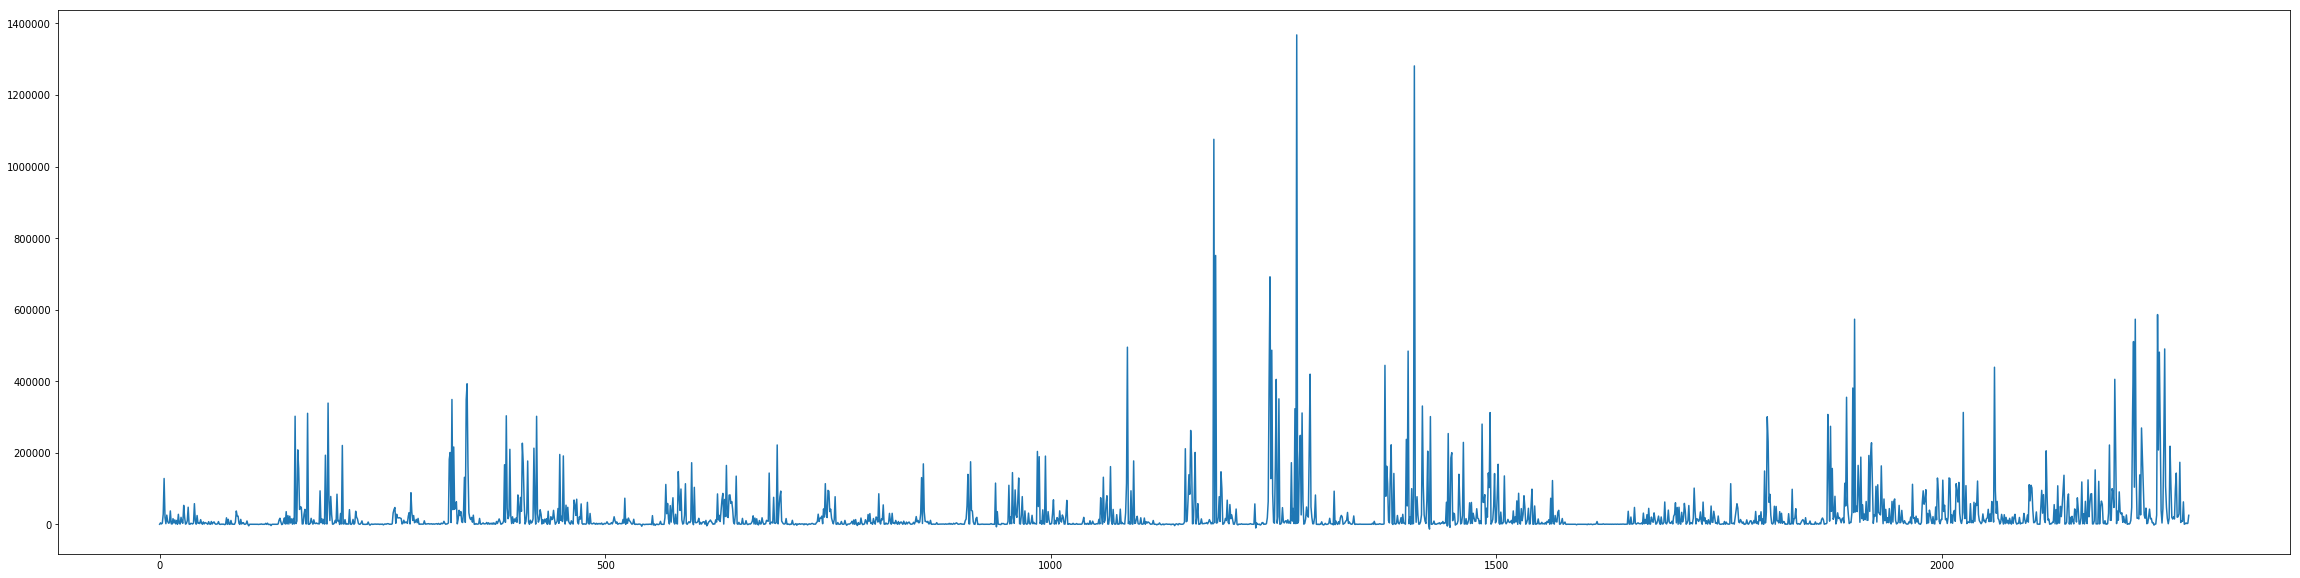

In [67]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(2278), edges_DKT_CC - edges_DKT)

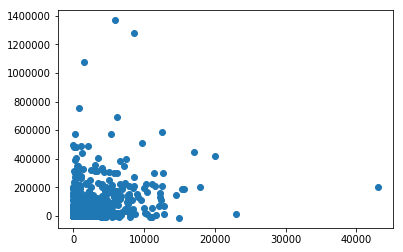

In [68]:
plt.scatter(edges_DKT, edges_DKT_CC - edges_DKT)

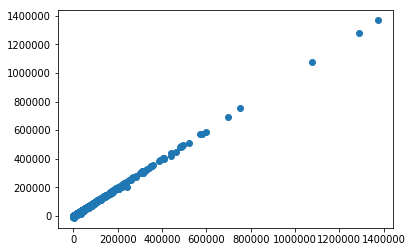

In [69]:
# Edge weights of DKT connectome vs Difference between DKT edge weights and DKT_CC edge weights
plt.scatter(edges_DKT_CC, edges_DKT_CC - edges_DKT)